# Optimisation
This notebook presents a procedure to optimize scenarios within AeroMAPS.

## Load

In [1]:

from typing import Tuple

from aeromaps import create_process
from aeromaps.core.models import models_optim_complex

from aeromaps.core.gemseo import CustomDataConverter

from gemseo.algos.design_space import DesignSpace

from gemseo.settings.opt import SLSQP_Settings
from gemseo.settings.opt import DIFFERENTIAL_EVOLUTION_Settings


import gemseo as gm
import warnings
import pandas as pd

from aeromaps.models.base import AeroMAPSModel, aeromaps_interpolation_function

from aeromaps.utils.functions import custom_logger_config

custom_logger_config(gm.configure_logger())

<RootLogger root (INFO)>

## Models

In [2]:
models_optim_complex["models_energy_without_fuel_effect"].pop("dropin_fuel_distribution")


# Custom dropin fuel distribution model for optimisation
class DropinFuelDistribution(AeroMAPSModel):
    def __init__(self, name="dropin_fuel_distribution", *args, **kwargs):
        super().__init__(name, *args, **kwargs)

    def compute(
        self,
        biofuel_share_optim: list,
        electrofuel_share_optim: list,
    ) -> Tuple[pd.Series, pd.Series, pd.Series]:
        """Fuel distribution calculation using interpolation functions"""

        biofuel_share = pd.Series(0.0, index=range(self.historic_start_year, self.end_year + 1))
        electrofuel_share = pd.Series(0.0, index=range(self.historic_start_year, self.end_year + 1))

        biofuel_share[2024] = 0.5
        biofuel_share_reference_years = [2025, 2030, 2035, 2040, 2045, 2050]
        biofuel_share_loc = biofuel_share_optim.copy()
        biofuel_share_loc.insert(0, 2)

        biofuel_share.loc[2025:2050] = aeromaps_interpolation_function(
            self,
            biofuel_share_reference_years,
            biofuel_share_loc,
            method="linear",
            positive_constraint=True,
            model_name=self.name,
        )

        self.df.loc[:, "biofuel_share"] = biofuel_share

        electrofuel_share_reference_years = [2025, 2030, 2035, 2040, 2045, 2050]
        electrofuel_share_loc = electrofuel_share_optim.copy()
        electrofuel_share_loc.insert(0, 0)

        # Electrofuel
        electrofuel_share.loc[2025:2050] = aeromaps_interpolation_function(
            self,
            electrofuel_share_reference_years,
            electrofuel_share_loc,
            method="linear",  # linear for optim
            positive_constraint=True,
            model_name=self.name,
        )

        self.df.loc[:, "electrofuel_share"] = electrofuel_share

        # Kerosene
        kerosene_share = 100 - biofuel_share - electrofuel_share
        self.df.loc[:, "kerosene_share"] = kerosene_share

        return biofuel_share, electrofuel_share, kerosene_share


models = {
    "models_optim_complex": models_optim_complex,
    "dropin_fuel_distribution": DropinFuelDistribution("dropin_fuel_distribution"),
}

## Process, data and compute

In [3]:
process = create_process(models=models)

Field Unnamed: 0 has an unexpected size 20


## Constraints definition

These standard constraints are defined in the source code; but as explained in create_a_custom_process, one can define other constraints directly, and add these to the set of models used.

In [4]:
# Carbon budget share
process.parameters.aviation_carbon_budget_objective = 3.6

# Biomass availability
process.parameters.biomass_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.biomass_availability_constraint_trajectory_reference_years_values = [
    62.8,
    72.1,
    97.8,
    101.8,
]

# Electricity availability
process.parameters.electricity_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.electricity_availability_constraint_trajectory_reference_years_values = [
    102.0456,
    137.5452,
    212.7996,
    276.6168,
]

# Volume and rate ramp up constraints
process.parameters.volume_ramp_up_constraint_biofuel = 0.3
process.parameters.rate_ramp_up_constraint_biofuel = 0.2

process.parameters.volume_ramp_up_constraint_electrofuel = 0.3
process.parameters.rate_ramp_up_constraint_electrofuel = 0.2


# Other settings

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0


## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 3.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 15.0
process.parameters.aviation_electricity_allocated_share = 8.0


### Biofuel and efuel reference years associated with the optim variables

process.parameters.biofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electrofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]

In [5]:
### Here as we are operating with a loop, we have to define initial values of an entry point, just as in use_varaible_demand example
process.parameters.price_elasticity = -0.9

process.parameters.airfare_per_rpk = pd.Series(
    0.082949239,
    index=range(process.parameters.historic_start_year, process.parameters.end_year + 1),
)

### Optimisation problem setup with GEMSEO

In [6]:
# Create a GEMSEO scenario

process.gemseo_settings["scenario_type"] = "MDO"
process.gemseo_settings["formulation"] = "MDF"


# define the design sapce: electrofuel and biofuel blending mandates

# NB: possible to modify DropinFuelDistribution to directly fix the first two values instead of creating frozen varaibles here, to reduce the design space size.

design_space = DesignSpace()
design_space.add_variable(
    "electrofuel_share_optim",
    size=5,
    lower_bound=[0, 0, 0, 0, 0],
    upper_bound=[100, 100, 100, 100, 100],
    value=[9.13249637, 14.68171346, 24.29143904, 41.14065492, 41.87052262],
)


design_space.add_variable(
    "biofuel_share_optim",
    size=5,
    lower_bound=[2, 2, 2, 2, 2],
    upper_bound=[100, 100, 100, 100, 100],
    value=[10.85689249, 16.98435693, 29.28238527, 32.74786858, 29.99980536],
)


process.gemseo_settings["design_space"] = design_space


# Define the objective
objective_name = "cumulative_total_surplus_loss_discounted_obj"
process.gemseo_settings["objective_name"] = objective_name


process.create_gemseo_scenario()
# Make optimisation objective values in the 1-10 interval
process.scenario.formulation.optimization_problem.objective = (
    process.scenario.formulation.optimization_problem.objective * 1e-13
)


# Add constraints
all_constraints = [
    "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "electricity_trajectory_constraint",
    "biomass_trajectory_constraint",
]


for constraint in all_constraints:
    process.scenario.add_constraint(constraint, constraint_type="ineq")


process.scenario.set_differentiation_method("finite_differences")

# Optim algo: COBYLA, a gradient-free non linear solver
# slsqp_settings = SLSQP_Settings(
#     max_iter=200,  # CAUTION, 2 set for quick automated test , use something like 200,
#     ftol_rel=0.001,
#     ftol_abs=0.001,
#     ineq_tolerance=0.015,
#     normalize_design_space=True,
# )

slsqp_settings = SLSQP_Settings(
    max_iter=20,  # CAUTION, 2 set for quick automated test , use something like 200,
    ftol_rel=0.001,
    ftol_abs=0.001,
    ineq_tolerance=0.015,
    normalize_design_space=True,
)

test_settings = slsqp_settings


process.gemseo_settings["algorithm"] = test_settings


# Adding design variables to the set of list types varaible (they are declared as ndarray but needed as lists within aeromaps functions)
CustomDataConverter._list_names.update(process.scenario.get_optim_variable_names())

In [7]:
warnings.filterwarnings("ignore")
process.compute()

    INFO - 16:31:52:  
    INFO - 16:31:52: *** Start MDOScenario execution ***
    INFO - 16:31:52: MDOScenario
    INFO - 16:31:52:    Disciplines: ASK BiofuelCostSimple BiofuelEfficiency BiofuelEmissionFactor BiofuelMfspSimple BiofuelProduction BiofuelUseGrowthConstraint BiomassAvailability BiomassAvailabilityConstraintTrajectory BiomassConsumption BlendCompletenessConstraint CO2Emissions CarbonBudgetConstraint CarbonBudgetConsumedShare CarbonOffset CarbonTax Co2Cost CumulativeCO2Emissions CumulativeCarbonOffset DetailedCo2Emissions DetailedCumulativeCO2Emissions DicountedEnergyCost DropInFuelConsumption DropInMeanMfsp DropinFuelConsumptionLiterPerPax100km DropinFuelDistribution DropinFuelPathwayConsumptionAndGrowth ElectricConsumption ElectricPathwayConsumptionAndGrowth ElectricityAvailability ElectricityAvailabilityConstraintTrajectory ElectricityBasedFuelEfficiency ElectricityConsumption ElectricityCost ElectricityDirectUse ElectricityEmissionFactor ElectrofuelCostSimple Electrof

Running MDO


    INFO - 16:37:10:     35%|███▌      | 7/20 [05:17<09:50,  1.32 it/min, obj=-0.109]
    INFO - 16:37:10: Optimization result:
    INFO - 16:37:10:    Optimizer info:
    INFO - 16:37:10:       Status: None
    INFO - 16:37:10:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 16:37:10:       Number of calls to the objective function by the optimizer: 8
    INFO - 16:37:10:    Solution:
    INFO - 16:37:10:       The solution is feasible.
    INFO - 16:37:10:       Objective: -0.10824387710595401
    INFO - 16:37:10:       Standardized constraints:
    INFO - 16:37:10:          aviation_carbon_budget_constraint = 2.555315842440366e-06
    INFO - 16:37:10:          biomass_trajectory_constraint = [-0.93762761 -0.84266335 -0.70847914 -0.64294834 -0.65767106]
    INFO - 16:37:10:          blend_completeness_constraint = [-0.95133557 -0.86082777 -0.71191373 -0.65291379 -0.67588984]
    INFO - 16:37:10: 

## Results

In [8]:
process = process

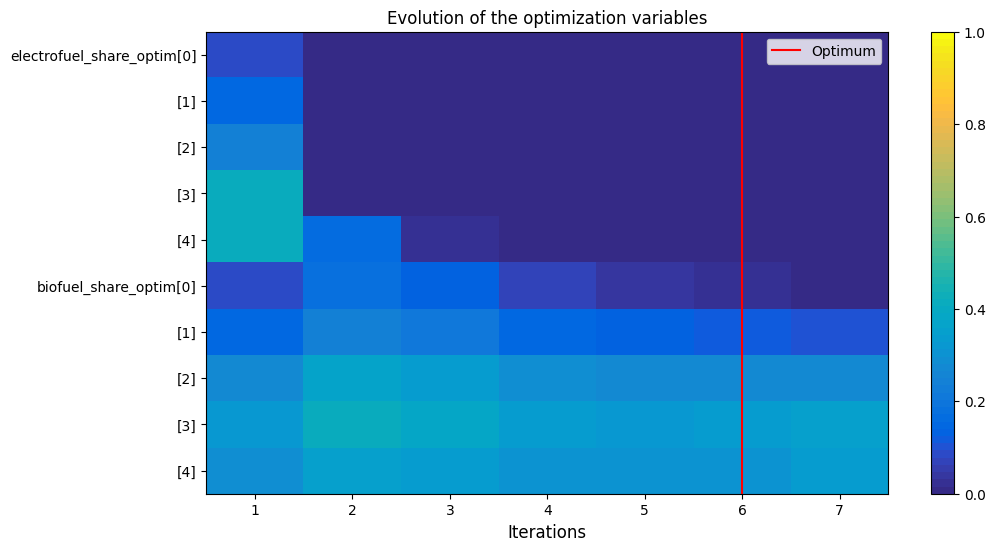

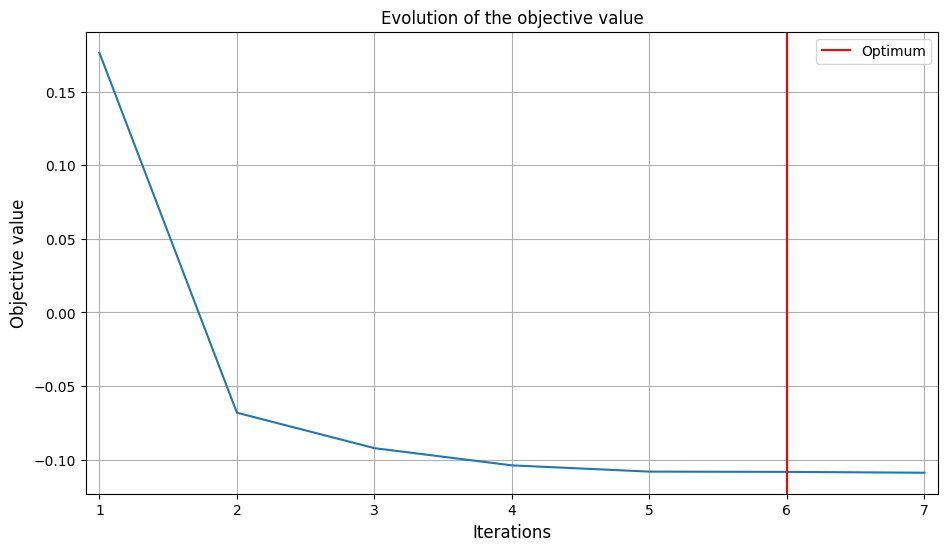

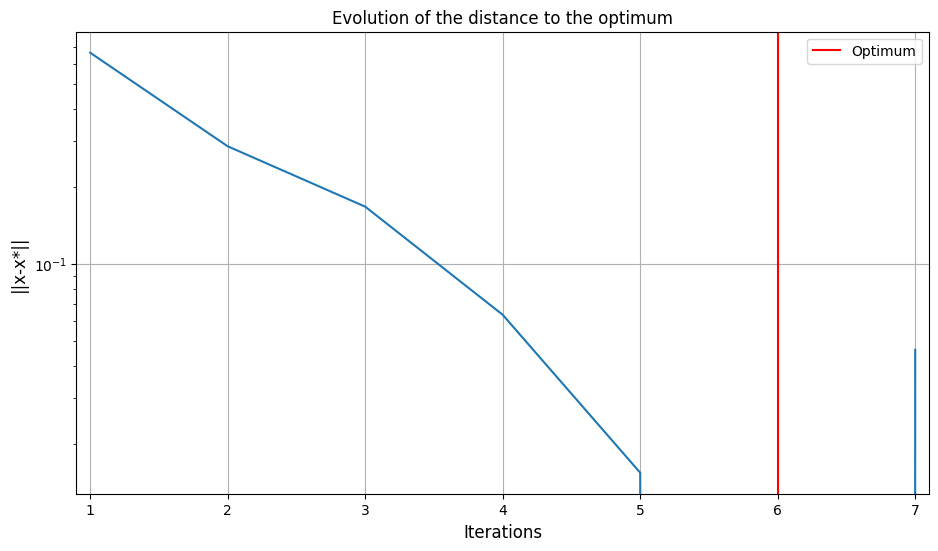

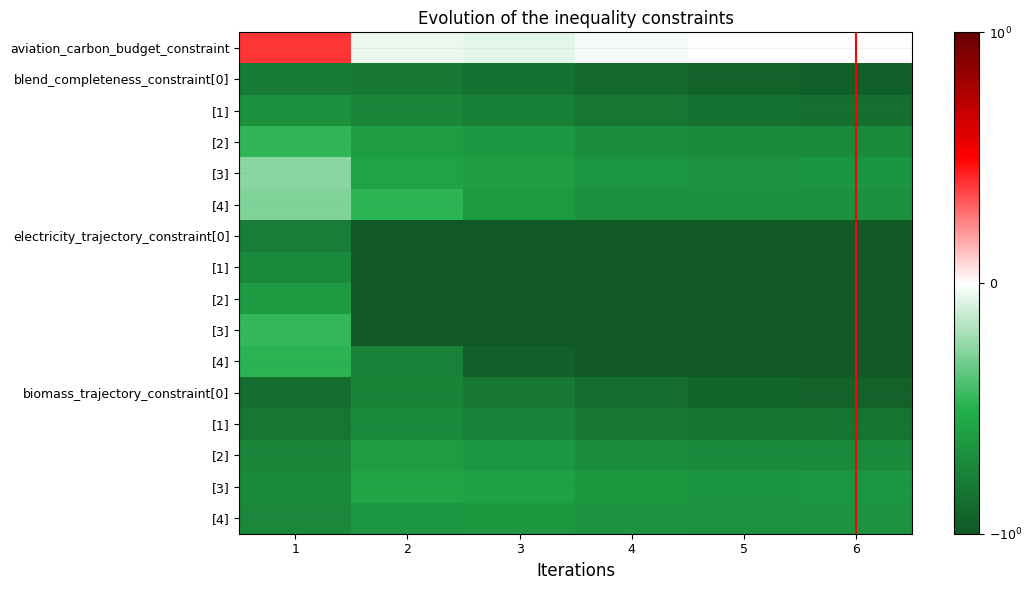

In [9]:
process.scenario.post_process(
    post_name="OptHistoryView",
    save=False,
    show=True,
)

In [10]:
process.scenario.get_result().design_variable_names_to_values

{'electrofuel_share_optim': array([9.87433505e-14, 4.07084033e-14, 3.18122082e-14, 0.00000000e+00,
        0.00000000e+00]),
 'biofuel_share_optim': array([ 4.86644265, 13.91722288, 28.8086273 , 34.70862123, 32.41101622])}

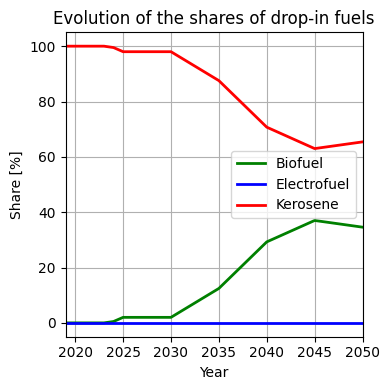

In [11]:
process.plot("dropin_fuel_shares")

In [12]:
from aeromaps.utils.functions import clean_notebooks_on_tests

clean_notebooks_on_tests(globals(), force_cleanup=True)

    INFO - 16:37:11: 🧹 clean_notebooks_on_tests called
    INFO - 16:37:11: 🧪 Detected test run or force cleanup
    INFO - 16:37:12: ✅ Cleaned up 36 variables
